## 빅데이터 실습

### 다나와 무선청소기 상품분석

#### 데이터 수집

##### 셀레니움 사용

In [1]:
## 필수 라이브러리 사용등록
from selenium import webdriver
from bs4 import BeautifulSoup
from urllib import parse # url encode
from tqdm import tqdm
import pandas as pd
import time

In [2]:
## 웹드라이버로 크롬 오픈
driver = webdriver.Chrome()
url = r'https://search.danawa.com/dsearch.php?k1=%EC%97%90%EC%96%B4%EB%A9%94%EC%9D%B4%EB%93%9C+%EC%8A%A4%EB%A7%88%ED%8A%B8%ED%83%80%EC%9B%8C&module=goods&act=dispMain'
driver.get(url)
time.sleep(5.0)

In [3]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [4]:
soup

<html class="js no-touch" lang="ko" xml:lang="ko" xmlns="http://www.w3.org/1999/xhtml"><head>
<title>에어메이드 스마트타워 : 다나와 통합검색</title>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/><meta content="IE=Edge" http-equiv="X-UA-Compatible"/><meta content="에어메이드 스마트타워 통합검색 : 다나와 통합검색" name="title"/>
<meta content="'에어메이드 스마트타워'의 다나와 통합검색 결과입니다." name="description"/>
<meta content="에어메이드 스마트타워, 다나와, 최저가, 가격비교, 검색, 통합검색, 상품 추천, 가격비교사이트, 가격비교 사이트, 가격비교 싸이트, 가격 검색, 추천, 인터넷쇼핑, 온라인쇼핑, 쇼핑, 쇼핑몰, 싸게 파는 곳, 지식쇼핑" name="keywords"/>
<meta content="에어메이드 스마트타워 통합검색 : 다나와 통합검색" property="og:title"/>
<meta content="'에어메이드 스마트타워'의 다나와 통합검색 결과입니다." property="og:description"/>
<meta content="https://img.danawa.com/new/tour/img/logo/sns_danawa.jpg" property="og:image"/>
<meta content="width=1280" name="viewport"/>
<link href="//img.danawa.com/new/danawa_main/v1/img/danawa_favicon.ico" rel="shortcut icon"/>
<link href="//static.danawa.com/css/common.css?v=2402280851" rel="stylesheet" type="text

In [5]:
prodItems = soup.select('ul.product_list > li.prod_item')

In [6]:
len(prodItems)

3

In [10]:
# id="productItem19965230" 식으로 전개되므로 productItem 이 아니면 패스
# 제품명 가져오기, 만약 애드스마트 영역이면 예외발생
prodItems[0].select('p.prod_name > a')[0].text.strip()

'에어메이드 스마트타워 AMC-3501A'

In [11]:
# 제품스펙 가져오기
prodItems[0].select('div.spec_list')[0].text.strip().replace('\t', '')

'핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 370W / 2024년형 / [구성] 먼지비움 / 충전 / UVC LED / 브러쉬: 바닥 / 침구 / 솔형 / 틈새 / 먼지봉투: 2.5L / [배터리] 사용시간: 40분(최대) / 충전시간: 5시간 / 분리형(1개) / 2500mAh / [청소] LED라이트 / BLDC모터 / [부가] 디스플레이표시 / 헤파필터 / 색상: 화이트 / 무게: 2.5kg / 크기(가로x세로x깊이): 252x1253x185mm'

In [17]:
# 만약 수가 아닌 문자열이 들어왔을때는 False
prodItems[0].select('input')[4].get('value').isdecimal()

False

##### 다나와 무선청소기 웹크롤링 다시
- 가격 외의 값은 들어오지 않도록 변환

In [18]:
## 검색어, 페이지를 변경하면서 URL 생성함수
def getSearchPageUrl(keyword, page):
    ecKeyword = parse.quote(keyword)
    url = f'https://search.danawa.com/dsearch.php?query={ecKeyword}&originalQuery={ecKeyword}&previousKeyword={ecKeyword}&checkedInfo=N&volumeType=allvs&' + \
          f'page={page}&limit=120&sort=saveDESC&list=list&boost=true&tab=goods&addDelivery=N&coupangMemberSort=N&mode=simple&isInitTireSmartFinder=N&' + \
           'recommendedSort=N&defaultUICategoryCode=10325109&defaultPhysicsCategoryCode=72%7C80%7C81%7C0&defaultVmTab=3138&defaultVaTab=1098867&isZeroPrice=Y&' + \
           'quickProductYN=N&priceUnitSort=N&priceUnitSortOrder=A'
    return url

In [19]:
## 상품정보 추출하는 함수
def getProdItems(prodItems):
    prodData = []

    for prodItem in prodItems:
        try:
            prodName = prodItem.select('p.prod_name > a')[0].text.strip()  # 상품명 가져오기
            specList = prodItem.select('div.spec_list')[0].text.strip().replace('\t', '') # 상품 스펙목록 가져오기
            
            if prodItem.select('input')[1].get('value').isdecimal()==True:
                price = prodItem.select('input')[1].get('value') # 최저가 가져오기        
            else:
                price = 0 # 문자열 들어오는것을 막음
            
            prodData.append([prodName, specList, price])
        except:
            pass
    
    return prodData

In [20]:
## 여러페이지 검색후 크롤링하는 작업
driver = webdriver.Chrome()
# 암묵적으로 웹 자원 로드를 위해 3초정도 대기
driver.implicitly_wait(3.0)

keyword = '무선청소기'
startPage = 1
totalPage = 20
prodDataTotal = [] # 최종적으로 저장할 리스트

for page in tqdm(range(startPage, totalPage +1)):
    # 검색 페이지 이동
    url = getSearchPageUrl(keyword, page)
    driver.get(url)
    # 페이지 로딩이 완료될때까지 5초간 대기
    time.sleep(5)

    # 현재 페이지 HTML 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')

    # 상품정보 추출
    prodItems = soup.select('ul.product_list > li.prod_item')
    prodItemList = getProdItems(prodItems) # 리스트로 추출하는 함수

    # 추출된 정보를 prodDataTotal 추가
    prodDataTotal += prodItemList   

100%|██████████| 20/20 [05:05<00:00, 15.28s/it]


In [22]:
dfProdDataTotal = pd.DataFrame(prodDataTotal)

In [23]:
dfProdDataTotal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2120 non-null   object
 1   1       2120 non-null   object
 2   2       2120 non-null   object
dtypes: object(3)
memory usage: 49.8+ KB


In [24]:
dfProdDataTotal.columns = ['제품명', '제품스펙', '최저가']

In [26]:
dfProdDataTotal.to_excel('./data/다나와_무선청소기_결과.xlsx', index=False)

#### 크롤링 데이터 전처리

In [29]:
# 저장한 엑셀을 재로드
dfProdDanawa = pd.read_excel('./data/다나와_무선청소기_결과.xlsx')
dfProdDanawa.tail()

,제품명,제품스펙,최저가
2115,미니센 무선 소형 청소기 MNC-100 먼지통,차량용청소기 / 먼지통,7000
2116,프리라벨 2in1 무선 진공 청소기 LS-2000 헤파필터,차량용청소기 / 필터 / [필터] 헤파필터,3500
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2118,포쉬 워시젯 V2 WJ200,침구청소기 / 핸디형 / 무선 / 사용시간: 25분(최대) / [기능] 청소모드: ...,219000
2119,업킵 MJ-BC779,침구청소기 / 핸디형 / 무선 / [기능] 청소모드: UV살균 / 속도조절 / 헤파...,89900


In [30]:
condition = dfProdDanawa['제품스펙'].isnull() == True

In [31]:
dfProdDanawa[condition]

,제품명,제품스펙,최저가
1846,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1861,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1910,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1925,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
1974,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
1989,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2038,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2053,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0
2102,스팀청소기 샤오미 무선 휴대용 자동차 진공 청소기 스마트 홈 흡입 및 블로잉 다기능...,NaN,0
2117,상품상세설명 참조 캐치웰 텀블러 디자인 초경량 무선 핸디형 진공청소기_아이언그레이,NaN,0


In [38]:
## 결측치가 있는 행(row) 삭제
dfProdDanawa = dfProdDanawa.dropna(axis=0)

In [40]:
condition = dfProdDanawa['최저가'] == 0

In [44]:
# 최저가가 0인 제품 제외한 나머지 저장
dfProdDanawa = dfProdDanawa[condition == False]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8636\2994184825.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfProdDanawa = dfProdDanawa[condition == False]


In [52]:
# 조건에 부합되는 행들이 삭제되면서 인덱스 꼬임, 인덱스 초기화
dfProdDanawa.reset_index(drop=True, inplace=True)

In [54]:
# 결측치, 이상치를 제거한 최종 DataFrame
# 2057개로 맞춰져야 함
dfProdDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2057 non-null   object
 1   제품스펙    2057 non-null   object
 2   최저가     2057 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 48.3+ KB


In [57]:
# 회사명, 제품명 분리(' ', n) n => 자를 공백의 번호
dfProdDanawa['제품명'][:5][0].split(' ', 1)

['LG전자', '오브제컬렉션 코드제로 A9S AX9884']

In [61]:
## 회사명, 모델명 분리 시작
comList = [] # 회사
modelList = [] # 모델
count = 0

for temp in dfProdDanawa['제품명']:
    titles = temp.split(' ', 1) # 길이 2 배열 생성
    if (len(titles) > 1):
        comList.append(titles[0]) # 회사명
        modelList.append(titles[1]) # 모델명
    else:
        comList.append(' ') # 회사명은 비움
        modelList.append(titles[0]) # 모델명
        
    count += 1

In [64]:
len(comList)

2057

In [65]:
len(modelList)

2057

In [66]:
# 스펙목록 데이터

In [81]:
# 스펙목록 데이터
specList = dfProdDanawa.loc[0, '제품스펙'].split(' / ')

In [91]:
useTime = ''
suctionPow = ''
for spec in specList:
    if '사용시간' in spec:
        useTime = spec
    elif '흡입력' in spec:
        suctionPow = spec
    
print(useTime.split(''[1]).strip())
print(suctionPow.split(''[1]).strip()) # 흡입력이 없어서 ''경우는 split(':')에서 예외발생

IndexError: string index out of range

In [102]:
## 위의 테스트를 기반으로 카테고리, 사용시간, 흡입력 추출
cateList = []
useTimeList = []
suctionPowList = []

for spec in dfProdDanawa['제품스펙']:
    # ' / '로 문자열 분리
    specList = spec.split(' / ')
    # 카테고리 추출
    category = specList[0]
    cateList.append(category)
    # 사용시간, 흡입력 추출
    useTimeVal = None
    suctionPowVal = None

    for temp in specList:
        if '사용시간' in temp:
            useTimeVal = temp
        elif '흡입력' in temp:
            suctionPowVal = temp
    
    # 끝난 다음에도 사용시간, 흡입력이 None이면 spec에 찾을 값이 없었다는 것
    if useTimeVal != None:
        useTime = useTimeVal.split(' ')[1].strip()
    else:
        useTime = ''

    if suctionPowVal != None:
        suctionPow = suctionPowVal.split(' ')[1].strip()
    else:
        suctionPow = ''
    
    useTimeList.append(useTime)
    suctionPowList.append(suctionPow)

In [ ]:
useTimeList

In [ ]:
suctionPowList

##### 무선청소기 분석전 결측치 제거

In [122]:
dfCleaner = pd.read_excel('./data/다나와_무선청소기_전처리결과.xlsx')

In [123]:
dfCleaner

,카테고리,회사명,모델명,가격,사용시간,흡입력
0,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9884,873560,30.0,250.0
1,핸디스틱청소기,삼성전자,비스포크 제트 VS20B956AX,446320,60.0,220.0
2,핸디스틱청소기,샤오미,미홀 M22,151050,NaN,NaN
3,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9604,715570,30.0,250.0
4,핸디스틱청소기,LG전자,오브제컬렉션 코드제로 A9S AX9988,1229240,60.0,280.0
...,...,...,...,...,...,...
2052,차량용청소기,미니센,무선 소형 청소기 MNC-100 노즐 세트,7000,NaN,NaN
2053,차량용청소기,미니센,무선 소형 청소기 MNC-100 먼지통,7000,NaN,NaN
2054,차량용청소기,프리라벨,2in1 무선 진공 청소기 LS-2000 헤파필터,3500,NaN,NaN
2055,침구청소기,포쉬,워시젯 V2 WJ200,219000,25.0,NaN


In [125]:
# 회사명 빠진 조건
condition = dfCleaner['회사명'].isnull()==True 

In [126]:
## 회사명 빠진것 10건은 수동으로 채워넣음
dfCleaner[condition]

,카테고리,회사명,모델명,가격,사용시간,흡입력


In [128]:
## 사용시간, 흡입력 Nan인 것은 전부 0으로 채워넣기
dfCleaner = dfCleaner.fillna(0)

In [130]:
dfCleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    2057 non-null   object 
 1   회사명     2057 non-null   object 
 2   모델명     2057 non-null   object 
 3   가격      2057 non-null   int64  
 4   사용시간    2057 non-null   float64
 5   흡입력     2057 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 96.6+ KB


##### 제품별 분석

In [132]:
# 카테고리별 제품 개수 -> 워드 클라우드 가능
dfCleaner['카테고리'].value_counts()

카테고리
핸디스틱청소기                1126
차량용청소기                  304
물걸레청소기                  217
침구청소기                    90
욕실청소기                    81
업소용청소기                   58
탁상용청소기                   52
핸디스틱청소기+로봇청소기            34
스틱청소기                    27
진공청소기                    18
창문청소기                    11
수영장청소기                   10
스팀청소기                     5
로봇청소기                     5
핸디/스틱청소기+핸디/스틱청소기         4
카펫소파청소기                   4
핸디스틱청소기+공기청정기세트           4
욕실+물걸레청소기                 1
핸디스틱청소기+핸디스틱청소기세트         1
핸디스틱청소기+가습기세트             1
핸디스틱청소기+공기청정기+가습기세트       1
신발세척기                     1
차량용선풍기                    1
핸디스틱청소기+물걸레청소기세트          1
Name: count, dtype: int64

In [133]:
dfCleaner['회사명'].value_counts()

회사명
삼성전자       144
LG전자       131
신일전자        88
다이슨         75
일렉트로룩스      66
          ... 
아이리          1
이나프          1
다기능          1
디자인에버        1
YINCHEN      1
Name: count, Length: 519, dtype: int64

##### 필요제품 선별

In [141]:
## 핸드스틱청소기만 선택해서 분석
dfDataFinal = dfCleaner[(dfCleaner['카테고리'].isin(['핸디스틱청소기', '핸디스틱청소기+로봇청소기', '스틱청소기', '진공청소기']))]

In [142]:
dfDataFinal.to_excel('./data/2_Danawa_data_final.xlsx', index=False)

##### 분석용 재로드

In [143]:
dfDataFinal = pd.read_excel('./data/2_Danawa_data_final.xlsx')

In [145]:
dfDataFinal.tail()

,카테고리,회사명,모델명,가격,사용시간,흡입력
1200,진공청소기,LG전자,코드제로 T9 T960D,1523960,0,250
1201,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0
1202,진공청소기,마끼다,DCL501,761200,0,66
1203,진공청소기,LG전자,코드제로 T9 T960D,1523960,0,250
1204,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0


In [148]:
# 흡입력 기준으로 정렬
suctionTopList = dfDataFinal.sort_values(['흡입력'], ascending=False)
suctionTopList.head()

,카테고리,회사명,모델명,가격,사용시간,흡입력
104,핸디스틱청소기,아이룸,윈드포스 F9,178000,40,420
334,핸디스틱청소기,비브르,V38 스페셜 에디션,195000,50,410
13,핸디스틱청소기,DIBEA,ALLNEW29000 PLUS,236550,50,400
128,핸디스틱청소기,DIBEA,ALLNEW22000+,199000,50,390
143,핸디스틱청소기,DIBEA,ALLNEW29000,249000,48,390


In [155]:
# 사용시간 기준 정렬
useTimeTopList = dfDataFinal.sort_values(['사용시간'] , ascending=False)
useTimeTopList.head()

,카테고리,회사명,모델명,가격,사용시간,흡입력
830,핸디스틱청소기,기펠,BTS-5000,471980,240,0
1020,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
277,핸디스틱청소기,무명,LT-124,29980,240,80
382,핸디스틱청소기,헤몬,ST-6655,39010,180,120
663,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225460,150,0


In [156]:
# 사용시간, 흡입력 동시 기준 정렬
topList = dfDataFinal.sort_values(['사용시간', '흡입력'] , ascending=False)
topList.head()

,카테고리,회사명,모델명,가격,사용시간,흡입력
277,핸디스틱청소기,무명,LT-124,29980,240,80
830,핸디스틱청소기,기펠,BTS-5000,471980,240,0
1020,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
382,핸디스틱청소기,헤몬,ST-6655,39010,180,120
663,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225460,150,0


In [165]:
## 가성비 좋은 제품 찾기 전
# 평균값
priceMean = int(dfDataFinal['가격'].mean()) # 49만원
suctionMean = dfDataFinal['흡입력'].mean() # 115.8
useTimeMean = dfDataFinal['사용시간'].mean() # 39분
print(f'평균가격 : {priceMean:,d}원, 평균흡입력 : {suctionMean:,.2f}W, 평균사용시간 : {useTimeMean:,.2f}분')

평균가격 : 469,697원, 평균흡입력 : 115.86W, 평균사용시간 : 39.51분


In [170]:
## 가성비 좋은 제품
cond1 = dfDataFinal['가격'] <= priceMean
cond2 = dfDataFinal['흡입력'] >= suctionMean
cond3 = dfDataFinal['사용시간'] >= useTimeMean

In [174]:
## 가성비 좋은 제품 검색
chartData = dfDataFinal[cond1 & cond2 & cond3]

##### 데이터 시각화

In [172]:
# 필요라이브러리 사용등록
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [194]:
# 한글 깨짐 문제 해결
from matplotlib import rcParams, font_manager,rc

font_path = 'C:/windows/Fonts/NanumGothicCoding.ttf'#나눔고딕체 사용
font = font_manager.FontProperties(fname=font_path).get_name() #실제 설치된 폰트 이름조회
rc('font', family=font) #한글깨짐현상 해결!!
rcParams['axes.unicode_minus']=False #한글 사용시 마이너스 표시 깨짐 해결!

In [203]:
## 흡입력, 사용시간, 최대값, 최소값
suctionMax = chartData['흡입력'].max() # 420
useTimeMax = chartData['사용시간'].max() # 180
suctionMean2 = chartData['흡입력'].mean()  # 229
useTimeMean2 = chartData['사용시간'].mean() # 51.9분

In [202]:
suctionMean2

229.69060773480663

In [190]:
sns.set_style('darkgrid')

In [191]:
## 불필요한 경고 메시지 제거
import warnings
warnings.filterwarnings('ignore')

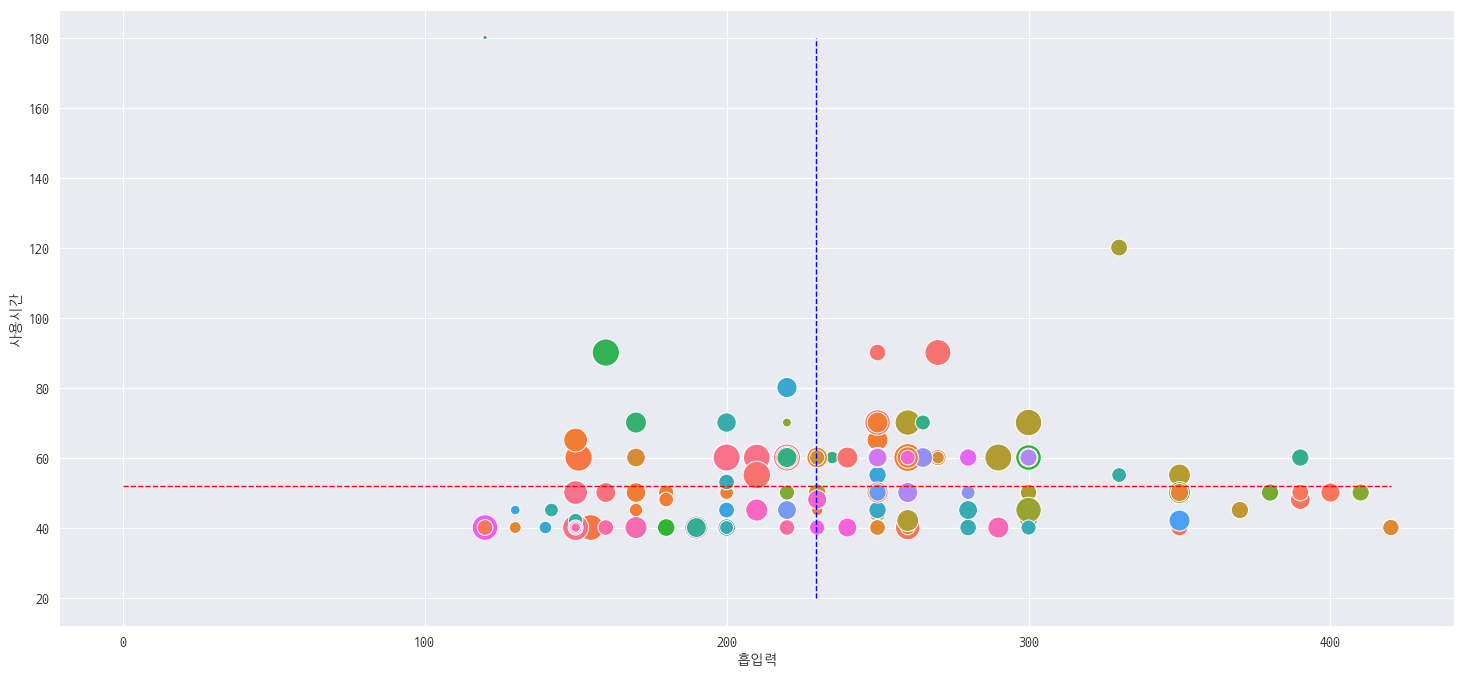

In [204]:
plt.figure(figsize=(18, 8))

sns.scatterplot(data=chartData, x='흡입력', y='사용시간', size='가격', sizes=(10, 400), hue=chartData['회사명'], legend=False)
plt.plot([0, suctionMax], [useTimeMean2, useTimeMean2], 'r--', lw=1) # 사용시간 평균치 줄표시
plt.plot([suctionMean2, suctionMean2], [20, useTimeMax], 'b--', lw=1) # 사용시간 평균치 줄표시

plt.show()

In [206]:
## 인기제품 데이터 시각화
chartDataTop = chartData[:20]

In [215]:
import random

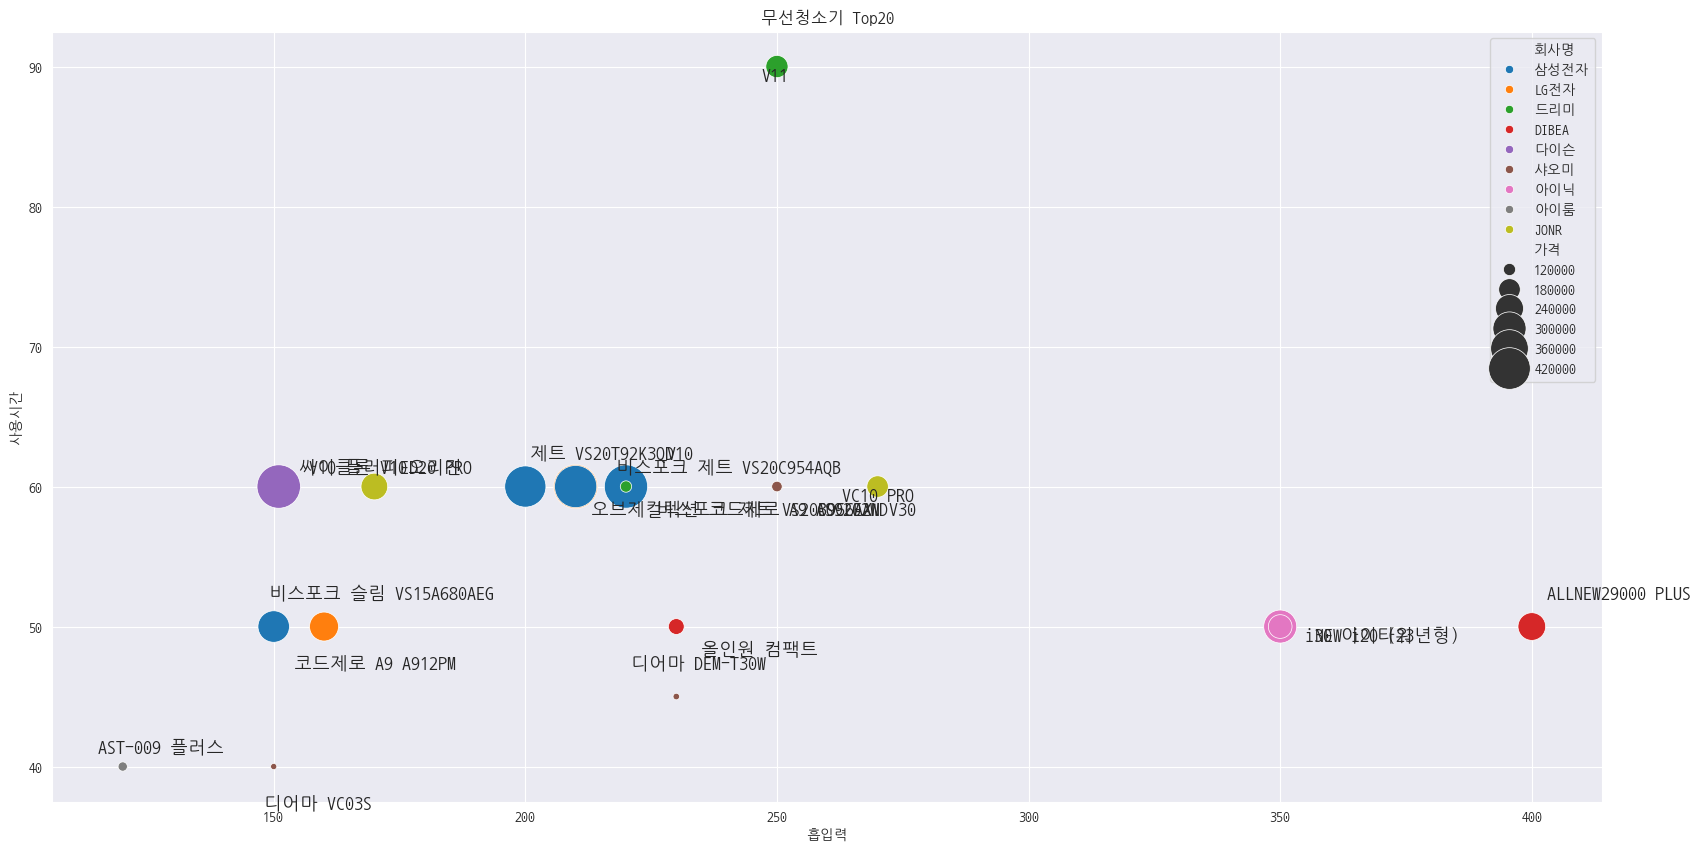

In [217]:
# 인기제품 시각화
fig = plt.figure(figsize=(20, 10))
plt.title('무선청소기 Top20')
sns.scatterplot(data=chartDataTop, x='흡입력', y='사용시간', size='가격', sizes=(20, 1000),
                hue=chartDataTop['회사명'])

for index, row in chartDataTop.iterrows():
    x = row['흡입력'] + random.randrange(-10, 10)
    y = row['사용시간'] + random.randrange(-3,3)
    s = row['모델명']
    plt.text(x, y, s, size=13)

plt.show()

##### 결론
- 데이터 분석을 위한 전처리 과정이 쉽지 않음
- 결과가 예상이나 실제와 다를 수 있음